<a href="https://colab.research.google.com/github/achett/Hierarchical-Model/blob/main/Revenue_FY23_Blind_Test_Enhancements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hierarchicalforecast
!pip install statsforecast
!pip install datasetsforecast
!pip install nixtlats>=0.1.0
!pip install darts
!pip install mlforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 636.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.2/508.2 kB 26.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.23.5 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.5/193.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 15.0 MB/s eta 0:00:00
  Created wheel for fugue-sql-antlr: filename=fugue_sql_antlr-0.2.0-py3-none-any.whl size=158196 sha256=6f383f3b3d0c4513e1dd3b1369d5a9097d604960bae6ca5992c3c4c56fd4baf3
  Stored in directory: /root/.cache/pip/wheels/5a/b

In [2]:
########################
# PACKAGES
########################
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
from datetime import datetime
from functools import reduce
from dateutil.relativedelta import relativedelta

from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive, AutoETS, AutoCES, AutoTheta
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import LabelEncoder

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace, OptimalCombination, ERM, PERMBU, Bootstrap, Normality
from hierarchicalforecast.utils import aggregate
from nixtlats import TimeGPT
os.environ['NIXTLA_ID_AS_COL'] = '1'


from darts import TimeSeries, concatenate
from darts.models import RegressionModel, LightGBMModel, ExponentialSmoothing, StatsForecastAutoETS, StatsForecastAutoARIMA, KalmanForecaster
from darts.dataprocessing.transformers import Scaler
from lightgbm import LGBMRegressor
from darts.metrics import mae, rmse, mape, mql, mse, ope
from darts.utils.likelihood_models import QuantileRegression

pd.options.display.float_format = '{:,.2f}'.format

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/nixtlats/__init__.py:5: FutureWarning: This package is deprecated, please install nixtla instead.
  warnings.warn("This package is deprecated, please install nixtla instead.", category=FutureWarning)


In [3]:
##############
# PARAMS
##############
fct_periods = 15
fct_st_date = '2023-04-01'
fct_end_date = '2024-03-01'

# Create hierarchical structure and constraints
hierarchy_levels = [['TopLv'],
                    ['TopLv', 'ProductLv'],
                    ['TopLv', 'ProductLv', 'Lv1'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4', 'Lv5']]

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/regional_hierarchy.xlsx'
sheet_name = 'regional_hierarchy v2'
r_hier = pd.read_excel(inputFile, sheet_name=sheet_name)

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/model_selection.xlsx'
model_selection = pd.read_excel(inputFile)

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/Product Naming Convention.xlsx'
product_naming_convention = pd.read_excel(inputFile)

In [4]:
##############
# FUNCTIONS
##############
def prepare_data(data, r_hier):

    # Merge hierarchy
    data = data.merge(r_hier, how='inner', left_on='cost_object', right_on='Lv5')

    # Transform date and y
    data['ds'] = pd.to_datetime(data['ds'])
    data['y'] = data['y'].astype(float)

    # Address NA values
    data['y'] = data['y'].fillna(0)
    data['TopLv'] = data['TopLv'].fillna('')
    data['Lv1'] = data['Lv1'].fillna('')
    data['Lv2'] = data['Lv2'].fillna('')
    data['Lv3'] = data['Lv3'].fillna('')
    data['Lv4'] = data['Lv4'].fillna('')
    data['Lv5'] = data['Lv5'].fillna('')
    data['product'] = data['product'].fillna('')

    # Create hierarchical dataframe
    data.rename(columns={'product': 'ProductLv'}, inplace=True)
    data = data[['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4', 'Lv5', 'ds', 'y']]

    # Replace '/' with '_' in the four columns
    data['TopLv'] = data['TopLv'].str.replace('/', '_')
    data['ProductLv'] = data['ProductLv'].str.replace('/', '_')
    data['Lv1'] = data['Lv1'].str.replace('/', '_')
    data['Lv2'] = data['Lv2'].str.replace('/', '_')
    data['Lv3'] = data['Lv3'].str.replace('/', '_')
    data['Lv4'] = data['Lv4'].str.replace('/', '_')
    data['Lv5'] = data['Lv5'].str.replace('/', '_')

    data['unique_id'] = data['TopLv'] + '/' + data['ProductLv'] + '/' + data['Lv1'] + '/' + data['Lv2'] + '/' + data['Lv3'] + '/' + data['Lv4'] + '/' + data['Lv5']

    # Assuming df is your existing DataFrame
    grouping_columns = ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4', 'Lv5', 'ds', 'unique_id']  # All columns except 'y'

    # Group by specified columns and sum 'y'
    data = data.groupby(grouping_columns)['y'].sum().reset_index()

    return data

def prepare_feature(data, r_hier, volume_act2, feature_name):

    # Select and rename columns
    data = data[['cost_object', 'product', 'ds', feature_name]].rename(columns={feature_name: 'y'})

    # Apply any additional preparation (assuming prepare_data is a function you have defined)
    data = prepare_data(data, r_hier)

    # Rename the columns back
    data = data.rename(columns={'y': feature_name})

    # Merge with the volume_act2 dataframe
    merged_df = data.merge(volume_act2[['unique_id', 'ds']], how='right', on=['unique_id', 'ds'])

    return merged_df


In [5]:
##############
# DATA LOAD
##############
inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/budgetFY23.csv'
budget = pd.read_csv(inputFile)
# budget = budget[budget['category']=='EQUIV_UNIT - Equivalent Units']
budget = budget[budget['category']=='UC110000 - Total Revenue']
budget.rename(columns={'country': 'cost_object'}, inplace=True)
budget = prepare_data(budget, r_hier)

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/revenue_output.csv'
volume_act = pd.read_csv(inputFile)
volume_act.rename(columns={'value': 'y'}, inplace=True)
volume_act = prepare_data(volume_act, r_hier)

inputFile = '/content/drive/MyDrive/Colab Notebooks/SGA Prediction/data/sga_output.csv'
sga = pd.read_csv(inputFile)

sga1 = prepare_feature(sga, r_hier, volume_act, 'AP')
sga2 = prepare_feature(sga, r_hier, volume_act, 'Field_Sales')

In [6]:
########################
# IDENTIFY UNIVERSE
########################
tested_ts = set(budget['unique_id'].unique()).intersection(volume_act['unique_id'].unique())

# Find unique IDs present in budget_h but not in rev
unique_ids_in_budget_not_in_rev = set(budget['unique_id'].unique()).difference(volume_act['unique_id'].unique())

# Find unique IDs present in rev but not in budget_h
unique_ids_in_rev_not_in_budget = set(volume_act['unique_id'].unique()).difference(budget['unique_id'].unique())

# Filter volume
volume_act = volume_act[volume_act['unique_id'].isin(tested_ts)]

In [7]:
########################
# SEGMENT TIME SERIES
########################
new_products = ['ENFORTUMAB - Enforumab Vedotin', 'ROXADUSTNT - Roxadustant']
loe_products = ['REGADENOSN - Regadenoson']
div_products = ['MICAFUNGIN - Micafungin Sodium']

new_ids = volume_act[volume_act['ProductLv'].isin(new_products)]['unique_id'].unique().tolist()
loe_ids = volume_act[volume_act['ProductLv'].isin(loe_products)]['unique_id'].unique().tolist()
divested_ids = volume_act[volume_act['ProductLv'].isin(div_products)]['unique_id'].unique().tolist()

# IDs with A&P and Field Sales Spend
grouped1 = sga1.groupby('unique_id')[['AP']].sum()
grouped2 = sga2.groupby('unique_id')[['Field_Sales']].sum()
spend_ids = set(grouped1[(grouped1['AP'] > 0)].index.tolist() + grouped2[(grouped2['Field_Sales'] > 0)].index.tolist())
spend_ids = spend_ids.difference(new_ids + loe_ids + divested_ids)

# IDs with no spend
non_spend_ids = volume_act[~volume_act['unique_id'].isin(spend_ids)]['unique_id'].unique()

# Model Selection
arima_regions = model_selection[model_selection['model']=='ARIMA']['Lv3'].unique()
ets_regions = model_selection[model_selection['model']=='ETS']['Lv3'].unique()
# arima_ids = volume_act[(volume_act['level3'].isin(arima_regions)) & (~volume_act['unique_id'].isin(spend_ids))]['unique_id'].unique().tolist()
# ets_ids = volume_act[(volume_act['level3'].isin(ets_regions)) & (~volume_act['unique_id'].isin(spend_ids))]['unique_id'].unique().tolist()

arima_ids = volume_act[(volume_act['Lv3'].isin(arima_regions))]['unique_id'].unique().tolist()
ets_ids = volume_act[(volume_act['Lv3'].isin(ets_regions))]['unique_id'].unique().tolist()

# Solifenacin _ Tamsulosin
solif_tams_ids = volume_act[volume_act['ProductLv'].isin(['SOLIF_TAMS - Solifenacin _ Tamsulosin', 'TAMSULOSIN - Tamsulosin HCl', 'TAMSUL_TAB - Tamsulosin tab'])]['unique_id'].unique().tolist()
arima_ids = set(arima_ids+solif_tams_ids)
ets_ids = [id for id in ets_ids if id not in solif_tams_ids]

In [8]:
########################
# DATA CONVERSION
########################
set2zero_list=['Global/TAMSULOSIN - Tamsulosin HCl/D_GCN - Greater China/D_CN_TOTAL - China Total/D_CN_TOTAL - China Total/D_CN_TOTAL - China Total/D_CN_TOTAL - China Total',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BENELUX - Benelux/D_E_BELGIUM - Belgium/D_E_BELGIUM - Belgium',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BBMCI - BBMCI group/D_E_BALKANS - Balkans/D_E_BOS_HER - Bosnia-Herz.',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BBMCI - BBMCI group/D_E_BALKANS - Balkans/D_E_BOS_HER - Bosnia-Herz.',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_ADRCS_PT - Adriatics & Portugal/D_E_ADRCS - Adriatic Adriatics/D_E_CROATIA - Croatia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_ADRCS_PT - Adriatics & Portugal/D_E_ADRCS - Adriatic Adriatics/D_E_CROATIA - Croatia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_CZSK - Czech + Slovakia/D_E_CZECH - Czech',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_GB - Great Britain/D_E_GB - Great Britain/D_E_GB - Great Britain/D_E_GB - Great Britain',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_HUBGROGR - HBRG/D_E_HUBGRO - Hungary  Bulgaria & Romania/D_E_HU - Hungary',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_IE - Ireland/D_E_IE - Ireland/D_E_IE - Ireland',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BBMCI - BBMCI group/D_E_MTCYIS - Malta  Cyprus & Iceland/D_E_MALTA - Malta',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_NORDIC - Nordic/D_E_NORWAY - Norway/D_E_NORWAY - Norway',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_PO - Poland/D_E_PO - Poland',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_PO - Poland/D_E_PO - Poland',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_CZSK - Czech + Slovakia/D_E_SLOVAKIA - Slovakia',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_SPAIN - Spain/D_E_SPAIN - Spain/D_E_SPAIN - Spain/D_E_SPAIN - Spain',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_UA - Ukraine/D_E_UA - Ukraine',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_UA - Ukraine/D_E_UA - Ukraine',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_GCN - Greater China/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_GCN - Greater China/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_OB - MEA Own Business/D_I_EGYPT - Egypt/D_I_EGYPT - Egypt/D_I_EGYPT - Egypt',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_INDONESIA - Indonesia/D_I_INDONESIA - Indonesia/D_I_INDONESIA - Indonesia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_DB - Distributor Business/D_I_IRAQ - Iraq/D_I_IRAQ - Iraq/D_I_IRAQ - Iraq',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_DB - Distributor Business/D_I_JORDAN - Jordan/D_I_JORDAN - Jordan/D_I_JORDAN - Jordan',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_LATAM - Domestic - LatAM/D_I_LATAM_REST - Domestic Rest of Latam/D_I_LATAM_REST_OTH - Domestic Rest of Latam Others/D_I_LATAM_REST_OTH - Domestic Rest of Latam Others',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_DB - Distributor Business/D_I_LEBANON - Lebanon/D_I_LEBANON - Lebanon/D_I_LEBANON - Lebanon',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_PHILIPPINES - Philippines/D_I_PHILIPPINES - Philippines/D_I_PHILIPPINES - Philippines',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_MEA_OB - MEA Own Business/D_I_SAFRICA - South Africa/D_I_SAFRICA - South Africa/D_I_SAFRICA - South Africa',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_SINMAL - SINMAL/D_I_SINGAPORE - SINGAPORE/D_I_SINGAPORE - SINGAPORE',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_TURKEY - Turkey/D_I_TURKEY - Turkey/D_I_TURKEY - Turkey/D_I_TURKEY - Turkey',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_VIETNAM - Vietnam/D_I_VIETNAM - Vietnam/D_I_VIETNAM - Vietnam',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_GCN - Greater China/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_GCN - Greater China/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total',
      'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BENELUX - Benelux/D_E_NETHLND - Netherlands/D_E_NETHLND - Netherlands',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_CZSK - Czech + Slovakia/D_E_SLOVAKIA - Slovakia',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_UA - Ukraine/D_E_UA - Ukraine',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_I_INTL - International Markets/D_I_LATAM - Domestic - LatAM/D_I_LATAM_DB - Domestic Latam Distributor Business/D_I_AR - Domestic Argentina/D_I_AR - Domestic Argentina',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan']

volume_act.loc[(volume_act['unique_id'].isin(set2zero_list)) & (volume_act['ds'] < '2022-04-01'), 'y'] = 0

In [9]:
########################
# SAMPLE
########################
ts2fix = ['Global/ROMOSOZUMA - ROMOSOZUMA/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/JP10 - Astellas Pharma Inc', 'Global/MIRABEGRON - Mirabegron/D_E_ESTMKT - Established Markets/D_E_CA - Canada/D_E_CA - Canada/D_E_CA - Canada/D_E_CA - Canada',
          'Global/MIRABEGRON - Mirabegron/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/US10 - Astellas Pharma US, Inc.', 'Global/ENZA - Enzalutamide/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/US10 - Astellas Pharma US, Inc.',
          'Global/ENZA - Enzalutamide/D_E_ESTMKT - Established Markets/D_E_DE - Germany/D_E_DE - Germany/D_E_DE - Germany/D_E_DE - Germany', 'Global/ENZA - Enzalutamide/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/JP10 - Astellas Pharma Inc',
          'Global/ENZA - Enzalutamide/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia']

volume_act = volume_act[volume_act['unique_id'].isin(ts2fix)]


In [10]:
########################
# RUN ETS & ARIMA
########################
def convert_fct2df(forecasts):
    forecast_dfs = []
    for unique_id, forecast_ts in forecasts.items():
        df = TimeSeries.quantiles_df(forecast_ts, quantiles=[0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995])
        df['unique_id'] = unique_id
        df = df.reset_index()
        df = df.rename(columns={'y_0.5': 'y'})
        forecast_dfs.append(df)

    # Concatenate all forecast DataFrames into a single DataFrame
    all_forecasts_df = pd.concat(forecast_dfs, axis=0)

    # Reorder and rename columns as needed
    columns = ['unique_id'] + [col for col in all_forecasts_df.columns if col != 'unique_id']
    all_forecasts_df = all_forecasts_df[columns]

    all_forecasts_df.columns.name = None

    return all_forecasts_df

def generate_time_series_dict(data, fct_periods, filter_data):
    # Split train/test sets
    test = data.groupby('unique_id').tail(fct_periods)
    train = data.drop(test.index)

    # Prepare time series dataframes
    time_series_dfs = {uid: group for uid, group in train.groupby('unique_id')}
    time_series_dict = {}

    if filter_data:
        # Filter out time series with insufficient non-zero data points
        filtered_time_series_dfs = {}
        for uid, group in time_series_dfs.items():
            non_zero_index = group['y'].ne(0).idxmax()
            start_index = max(0, non_zero_index - (13 - 1))
            filtered_df = group.loc[non_zero_index:] if group.loc[non_zero_index:].shape[0] >= 13 else group.loc[start_index:]
            if not filtered_df.empty:
                filtered_time_series_dfs[uid] = filtered_df
        # Convert each filtered DataFrame into a Darts TimeSeries object

        time_series_dict = {uid: TimeSeries.from_dataframe(group, 'ds', 'y') for uid, group in filtered_time_series_dfs.items()}
    else:
        # Convert each original DataFrame into a Darts TimeSeries object without filtering
        time_series_dict = {uid: TimeSeries.from_dataframe(group, 'ds', 'y') for uid, group in time_series_dfs.items()}

    return time_series_dict

def generate_forecast(data, fct_periods, model2use, filter_data=True):

    # Use the nested function to generate the time series dictionary
    time_series_dict = generate_time_series_dict(data, fct_periods, filter_data)

    # Create and fit a model for each time series
    models = {}
    for uid, series in time_series_dict.items():
        model = get_model(model2use)
        model.fit(series)
        models[uid] = model

    # Forecasting
    fct_dict = {uid: model.predict(fct_periods, num_samples=1000) for uid, model in models.items()}

    # Convert forecasts into a dataframe
    fct_df = convert_fct2df(fct_dict)
    print('hi')
    return fct_dict, fct_df

# Function to dynamically get the model instance
def get_model(model_name):
    if model_name == 'AutoETS':
        return StatsForecastAutoETS()
    elif model_name == 'ARIMA':
        return StatsForecastAutoARIMA(season_length=12)
    elif model_name == 'KF':
        return KalmanForecaster(dim_x=12)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

# q = volume_act[volume_act['unique_id']=='Global/AMPHOTERCN - Amphotericin B/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/US10 - Astellas Pharma US, Inc.']

# Check if 'ets_ids' list has values before running 'AutoETS' model
if ets_ids:
    ets_filtered_data = volume_act[volume_act['unique_id'].isin(ets_ids)]
    if not ets_filtered_data.empty:  # Also check if the filtered DataFrame is not empty
        ets_dict, ets_df = generate_forecast(ets_filtered_data, fct_periods, model2use='AutoETS', filter_data=True)

# Check if 'arima_ids' list has values before running 'ARIMA' model
if arima_ids:
    arima_filtered_data = volume_act[volume_act['unique_id'].isin(arima_ids)]
    if not arima_filtered_data.empty:  # Also check if the filtered DataFrame is not empty
        arima_dict, arima_df = generate_forecast(arima_filtered_data, fct_periods, model2use='ARIMA', filter_data=True)

# You can uncomment the following line if you want to always run 'KF' model regardless of filtering
# kf_fct = generate_forecast(volume_act, fct_periods, model2use='KF', filter_data=True)



hi
hi


In [11]:
########################
# XTREND - DECAY
########################
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np

def apply_exponential_decay(df, start_date, end_date, end_value_percentage, target_unique_ids):

    # Convert 'ds' to datetime if it's not already and sort
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values(by='ds')
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Loop through each group (unique_id)
    for unique_id in target_unique_ids:
        group = df[df['unique_id'] == unique_id]

        # Columns to apply decay to
        decay_columns = [col for col in group.columns if col not in ['unique_id', 'ds']]

        # Initialize a dictionary to keep the end values for each decay column
        end_values = {}

        # Find start and end values and dates for each column
        for col in decay_columns:
            if start_date in group['ds'].values and end_date in group['ds'].values:
                start_value = group.loc[group['ds'] == start_date, col].iloc[0]
                end_value = start_value * end_value_percentage
                end_values[col] = end_value  # Store the end value for this column

                # Calculate the decay rate based on exponential decay formula
                months = relativedelta(end_date, start_date).months
                decay_rate = np.log(end_value / start_value) / months

                # Apply exponential decay for dates between start_date and end_date
                for date in pd.date_range(start_date, end_date):
                    if date in group['ds'].values:
                        t = relativedelta(date, start_date).months
                        new_value = start_value * np.exp(decay_rate * t)
                        df.loc[(df['unique_id'] == unique_id) & (df['ds'] == date), col] = new_value

        # Replace column values for dates after end_date with the respective end values
        for col, end_value in end_values.items():
            if end_value is not None:  # Ensure there was an end value calculated
                df.loc[(df['unique_id'] == unique_id) & (df['ds'] > end_date), col] = end_value

    return df


# Apply exponential decay
# lgbm_fct.rename(columns={'LGBM': 'y'}, inplace=True)
ets_df.rename(columns={'ETS': 'y'}, inplace=True)
arima_df.rename(columns={'ARIMA': 'y'}, inplace=True)

# Micafungin
arima_df = apply_exponential_decay(arima_df, '2023-07-01', '2023-08-01', 0, divested_ids)
ets_df = apply_exponential_decay(ets_df, '2023-07-01', '2023-08-01', 0, divested_ids)

# Lexiscan
arima_df = apply_exponential_decay(arima_df, '2023-01-01', '2023-12-01', .1, loe_ids)
ets_df = apply_exponential_decay(ets_df, '2023-01-01', '2023-12-01', .1, loe_ids)

# # Tamsulosin
# tamsulosin_ids = volume_act[volume_act['ProductLv'].isin(['TAMSULOSIN - Tamsulosin HCl', 'TAMSUL_TAB - Tamsulosin tab'])]['unique_id'].unique()
# arima_df = apply_exponential_decay(arima_df, '2023-04-01', '2023-12-01', .9, tamsulosin_ids)
# ets_df = apply_exponential_decay(ets_df, '2023-04-01', '2023-12-01', .9, tamsulosin_ids)

# Solifinacin Tamsulosin
solif_tams_ids = volume_act[(volume_act['ProductLv'].isin(['SOLIF_TAMS - Solifenacin _ Tamsulosin'])) & (volume_act['Lv5'].isin(['D_E_PORTUGAL - Portugal', 'D_E_SPAIN - Spain', 'D_E_GB - Great Britain', 'D_E_BG - Bulgaria']))]['unique_id'].unique()
arima_df = apply_exponential_decay(arima_df, '2023-06-01', '2023-12-01', .7, solif_tams_ids)
ets_df = apply_exponential_decay(ets_df, '2023-06-01', '2023-12-01', .7, solif_tams_ids)

# Xtandi
xtandi_ids = volume_act[(volume_act['ProductLv'].isin(['ENZA - Enzalutamide']))]['unique_id'].unique()
arima_df = apply_exponential_decay(arima_df, '2027-11-01', '2028-11-01', .1, xtandi_ids)
ets_df = apply_exponential_decay(ets_df, '2027-11-01', '2028-11-01', .1, xtandi_ids)

# Mirabegron
mira_ids = volume_act[(volume_act['ProductLv'].isin(['MIRABEGRON - Mirabegron']))]['unique_id'].unique()
arima_df = apply_exponential_decay(arima_df, '2025-11-01', '2026-11-01', .1, mira_ids)
ets_df = apply_exponential_decay(ets_df, '2025-11-01', '2026-11-01', .1, mira_ids)

# Cresemba
cres_ids = volume_act[(volume_act['ProductLv'].isin(['ISA_SULFAT - Isavuconazonium Sulfate']))]['unique_id'].unique()
arima_df = apply_exponential_decay(arima_df, '2027-03-01', '2028-03-01', .1, cres_ids)
ets_df = apply_exponential_decay(ets_df, '2027-03-01', '2028-03-01', .1, cres_ids)

In [12]:
########################
# CREATE ANALYTICAL TABLE
########################
# Subset
volume_act_xsm = volume_act[['unique_id', 'ds', 'y']]
budget2 = budget[['unique_id', 'ds', 'y']]
ets_df2 = ets_df[['unique_id', 'ds', 'y']]
arima_df2 = arima_df[['unique_id', 'ds', 'y']]

# Assign names
volume_act_xsm.rename(columns={'y': 'Actuals'}, inplace=True)
budget2.rename(columns={'y': 'Budget'}, inplace=True)
ets_df2.rename(columns={'y': 'ETS'}, inplace=True)
arima_df2.rename(columns={'y': 'ARIMA'}, inplace=True)

# Merge actuals, budget and forecast
rev_at = volume_act_xsm.merge(ets_df2, on=['unique_id', 'ds'], how='left')
rev_at = rev_at.merge(budget2, on=['unique_id', 'ds'], how='left')
rev_at = rev_at.merge(arima_df2, on=['unique_id', 'ds'], how='left')

# Conditions for selection
conditions = [rev_at['unique_id'].isin(arima_ids),rev_at['unique_id'].isin(ets_ids)]
choices = [rev_at['ARIMA'],rev_at['ETS']]

# Creating the new column 'SelectedFCT' based on the conditions
rev_at['SelectedFCT'] = np.select(conditions, choices, default=np.nan)

# Only keep tested ts
rev_at = rev_at[rev_at['unique_id'].isin(tested_ts)]

<ipython-input-12-a432f2869c38>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volume_act_xsm.rename(columns={'y': 'Actuals'}, inplace=True)
<ipython-input-12-a432f2869c38>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  budget2.rename(columns={'y': 'Budget'}, inplace=True)
<ipython-input-12-a432f2869c38>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ets_df2.rename(columns={'y': 'ETS'}, inplace=True)
<ipython-input-12-a432f286

In [13]:
########################
# CREATE DATA2PLOT
########################
# Add revenue actuals
data2plot = rev_at.copy()
data2plot = data2plot[['unique_id', 'ds', 'Actuals']]
data2plot['ds'] = pd.to_datetime(data2plot['ds'])

# Update Actuals columns
data2plot['Actuals (Train)'] = data2plot['Actuals'].copy()
data2plot['Actuals'] = data2plot.apply(lambda row: row['Actuals'] if row['ds'] >= datetime.strptime(fct_st_date, "%Y-%m-%d") else None, axis=1)
data2plot['Actuals (Train)'] = data2plot.apply(lambda row: row['Actuals (Train)'] if row['ds'] < datetime.strptime(fct_st_date, "%Y-%m-%d") else None, axis=1)

# Add forecast and budget
data2plot = data2plot.merge(rev_at[['unique_id', 'ds', 'SelectedFCT']], how='left', on=['unique_id', 'ds'])
data2plot = data2plot.merge(rev_at[['unique_id', 'ds', 'Budget']], how='left', on=['unique_id', 'ds'])

data2plot.head()

,unique_id,ds,Actuals,Actuals (Train),SelectedFCT,Budget
0,Global/ENZA - Enzalutamide/D_E_ESTMKT - Establ...,2014-04-01,NaN,"747,123,795.50",NaN,NaN
1,Global/ENZA - Enzalutamide/D_E_ESTMKT - Establ...,2014-05-01,NaN,"747,123,795.50",NaN,NaN
2,Global/ENZA - Enzalutamide/D_E_ESTMKT - Establ...,2014-06-01,NaN,"744,665,855.44",NaN,NaN
3,Global/ENZA - Enzalutamide/D_E_ESTMKT - Establ...,2014-07-01,NaN,"856,639,324.66",NaN,NaN
4,Global/ENZA - Enzalutamide/D_E_ESTMKT - Establ...,2014-08-01,NaN,"848,185,564.20",NaN,NaN


In [14]:
########################
# PLOT
########################
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import base64
from io import BytesIO

# Update the function to include filtering based on 'unique_id'
def plot_data(unique_id):
    # Define x_column and y_columns directly
    x_column = data2use.columns[1]
    y_columns = [data2use.columns[2], data2use.columns[3], data2use.columns[4], data2use.columns[5]]

    # Filter data based on selected unique_id
    filtered_data = data2use[data2use['unique_id'] == unique_id]

    # Set up a 1x3 grid of subplots
    fig, (ax1, ax4) = plt.subplots(1, 2, figsize=(25, 5), gridspec_kw={'width_ratios': [4, 1]}) # Adjust layout for table

    # Plotting multiple y-axes on the first subplot
    for y_column in y_columns:
        ax1.plot(filtered_data[x_column], filtered_data[y_column], label=y_column)
    ax1.set_xlabel(x_column)
    ax1.set_ylabel('Values')
    ax1.set_title(f'Revenue for {unique_id}')
    ax1.legend()

    # Remove axis for table
    ax4.axis('off')
    ax4.axis('tight')

    # Displaying the sum table
    display_data = filtered_data[[x_column] + list(y_columns)].copy()
    display_data = display_data[display_data['ds']>=fct_st_date]
    display_data['ds'] = display_data['ds'].dt.strftime('%m/%d/%Y')

    # Create a sum row
    sum_values = {x_column: 'Sum'}
    for col in list(y_columns):
        sum_values[col] = display_data[col].sum()
    sum_row = pd.DataFrame([sum_values])

    # Create a % diff row
    actuals_sum = sum_values['Actuals']
    pdiff_values = {x_column: '% Diff'}
    for col in list(y_columns):
        pdiff_values[col] = ((display_data[col].sum()-actuals_sum) / actuals_sum) * 100 if actuals_sum != 0 else None
        pdiff_values[col] = round(pdiff_values[col], 2)
    perc_diff_row = pd.DataFrame([pdiff_values])

    # Stack the sum row
    display_data = pd.concat([sum_row, display_data], ignore_index=True)

    # Round the values and add commas
    for column in y_columns:
        if column in display_data.columns:
            # Round to two decimal places
            display_data[column] = display_data[column].round(2)
            # Format with commas
            display_data[column] = display_data[column].apply(lambda x: f"{x:,.2f}")

    # Stack the % diff and remove 'Actuals Train'
    display_data = pd.concat([perc_diff_row, display_data], ignore_index=True)
    display_data = display_data.drop('Actuals (Train)', axis=1)

    # Convert perc_diff_data to array for table
    table_data = display_data.to_numpy()
    # Add table at the right
    table = ax4.table(cellText=table_data, colLabels=display_data.columns, loc='right')
    table.auto_set_font_size(False)
    table.set_fontsize(8.5)  # Set smaller font size if necessary
    table.scale(4, 1.8)  # Adjust scale to fit

    plt.tight_layout()
    plt.show()


# data2use = ts2fix
# data2use = tsnonspend
data2use = data2plot
# data2use = rev_at_hier2plot

substring1 = 'romos'
substring2 = 'romos'

# Update data2use to include rows where 'unique_id' contains either substring1 or substring2
# data2use = data2use[data2use['unique_id'].str.contains(substring1 + '|' + substring2, case=False, na=False)]

# data2use = data2use[data2use['unique_id'].str.contains(substring1, case=False, na=False) &
#                     data2use['unique_id'].str.contains(substring2, case=False, na=False)]



# Create widgets
unique_id_selector = widgets.SelectionSlider(
    options=data2use['unique_id'].unique(),
    description='unique_id:',
    orientation='horizontal',
    readout=True
)

# Display interactive plot
interact(plot_data, unique_id=unique_id_selector)

interactive(children=(SelectionSlider(description='unique_id:', options=('Global/ENZA - Enzalutamide/D_E_ESTMK…

<function __main__.plot_data(unique_id)>

In [15]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt



In [16]:
"""
Univariate Local Linear Trend Model
"""
class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1, 0])
        self.ssm['transition'] = np.array([[1, 1],
                                       [0, 1]])
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        return [np.std(self.endog)]*3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]


In [17]:
import numpy as np
import statsmodels.api as sm

class SeasonalLocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, seasonal_period):
        # Model order
        k_states = 2 + seasonal_period  # level, trend, and seasonal dummies
        k_posdef = 3  # noise for level, trend, and general seasonal effect

        # Initialize the statespace
        super(SeasonalLocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.zeros((1, k_states))
        self.ssm['design', 0, 0] = 1  # Observation on level only

        self.ssm['transition'] = np.zeros((k_states, k_states))
        self.ssm['transition'][0, 0] = 1
        self.ssm['transition'][0, 1] = 1
        self.ssm['transition'][1, 1] = 1
        # Set up seasonal transitions
        for i in range(2, 2 + seasonal_period):
            if i == (2 + seasonal_period - 1):
                self.ssm['transition'][i, 2] = 1  # Cycle back to the first seasonal dummy
            else:
                self.ssm['transition'][i, i + 1] = 1

        # Selection matrix with correct dimensions
        self.ssm['selection'] = np.zeros((k_states, k_posdef))
        self.ssm['selection'][0, 0] = 1  # level noise
        self.ssm['selection'][1, 1] = 1  # trend noise
        self.ssm['selection'][2, 2] = 1  # seasonal noise at the first seasonal dummy

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend', 'sigma2.seasonal']

    @property
    def start_params(self):
        return [np.std(self.endog)] * 4

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(SeasonalLocalLinearTrend, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov', 0, 0] = params[0]

        # State covariance for level, trend, and seasonal
        self.ssm[self._state_cov_idx[0], 0, 0] = params[1]
        self.ssm[self._state_cov_idx[0], 1, 1] = params[2]
        self.ssm[self._state_cov_idx[0], 2, 2] = params[3]




In [125]:
# unrestricted_model_evenity = {
#     'irregular': True, 'autoregressive': None,
#     'level': True, 'stochastic_level': True,
#     'trend': True, 'stochastic_trend': True,
#     'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True,
#     'seasonal': 12, 'stochastic_seasonal': True
# }
# id2test = 'Global/ROMOSOZUMA - ROMOSOZUMA/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/JP10 - Astellas Pharma Inc'

# unrestricted_model_enza_us = {
#     'irregular': True, 'autoregressive': None,
#     'level': True, 'stochastic_level': True,
#     'trend': True, 'stochastic_trend': False,
#     'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True,
#     'seasonal': 12, 'stochastic_seasonal': False
# }
# id2test = 'Global/ENZA - Enzalutamide/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/US10 - Astellas Pharma US, Inc.'

# unrestricted_model_mira_us = {
#     'irregular': True, 'autoregressive': None,
#     'level': True, 'stochastic_level': True,
#     'trend': True, 'stochastic_trend': True,
#     'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True,
#     'seasonal': 12, 'stochastic_seasonal': True
# }

# id2test = 'Global/MIRABEGRON - Mirabegron/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/US10 - Astellas Pharma US, Inc.'

# unrestricted_model_enza_de = {
#     'irregular': True, 'autoregressive': None,
#     'level': True, 'stochastic_level': True,
#     'trend': True, 'stochastic_trend': False,
#     'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True,
#     'seasonal': 12, 'stochastic_seasonal': True
# }

# id2test = 'Global/ENZA - Enzalutamide/D_E_ESTMKT - Established Markets/D_E_DE - Germany/D_E_DE - Germany/D_E_DE - Germany/D_E_DE - Germany'

# unrestricted_model_enza_jp = {
#     'irregular': True, 'autoregressive': None,
#     'level': True, 'stochastic_level': True,
#     'trend': True, 'stochastic_trend': False,
#     'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True,
#     'seasonal': 12, 'stochastic_seasonal': True
# }

# id2test = 'Global/ENZA - Enzalutamide/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/JP10 - Astellas Pharma Inc'

# unrestricted_model_enza_ru = {
#     'irregular': True, 'autoregressive': None,
#     'level': True, 'stochastic_level': True,
#     'trend': True, 'stochastic_trend': False,
#     'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True,
#     'seasonal': 12, 'stochastic_seasonal': True
# }

# id2test = 'Global/ENZA - Enzalutamide/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia'

# unrestricted_model_mira_ca = {
#     'irregular': False, 'autoregressive': None,
#     'level': True, 'stochastic_level': True,
#     'trend': True, 'stochastic_trend': True,
#     'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False,
#     'seasonal': 12, 'stochastic_seasonal': True
# }

# id2test = 'Global/MIRABEGRON - Mirabegron/D_E_ESTMKT - Established Markets/D_E_CA - Canada/D_E_CA - Canada/D_E_CA - Canada/D_E_CA - Canada'


In [126]:


ssm_data = volume_act.copy()
ssm_data = ssm_data[ssm_data['unique_id']==id2test]

ssm_data = ssm_data[['ds', 'y']]
ssm_data = ssm_data.set_index('ds')

# Set train and test period
ssm_test = ssm_data.tail(fct_periods)
ssm_train = ssm_data.drop(ssm_test.index)

# Setup the model
# mod = LocalLinearTrend(ssm_train['y'])
# res = mod.fit(disp=False)

# mod = SeasonalLocalLinearTrend(ssm_train['y'], 12)
# res = mod.fit(disp=False)

mod = sm.tsa.UnobservedComponents(ssm_train['y'], **unrestricted_model_mira_ca)
res = mod.fit(method='powell', disp=False)

print(res.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                            Unobserved Components Results                            
Dep. Variable:                             y   No. Observations:                  105
Model:                                  None   Log Likelihood               -1772.471
                   + stochastic seasonal(12)   AIC                           3552.941
                                     + cycle   BIC                           3562.941
Date:                       Sun, 28 Apr 2024   HQIC                          3556.974
Time:                               18:48:37                                         
Sample:                           04-01-2014                                         
                                - 12-01-2022                                         
Covariance Type:                         opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3014: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


In [127]:
# Perform prediction and forecasting
predict = res.get_prediction()
forecast = res.get_forecast('2024-04-01')

actuals_fy23 = ssm_test.loc[ssm_test.index >= fct_st_date]['y'].sum()
forecast_fy23 = forecast.predicted_mean.loc[forecast.predicted_mean.index >= fct_st_date].sum()

error = ((forecast_fy23-actuals_fy23)/actuals_fy23)*100
error

-0.4991955821232543

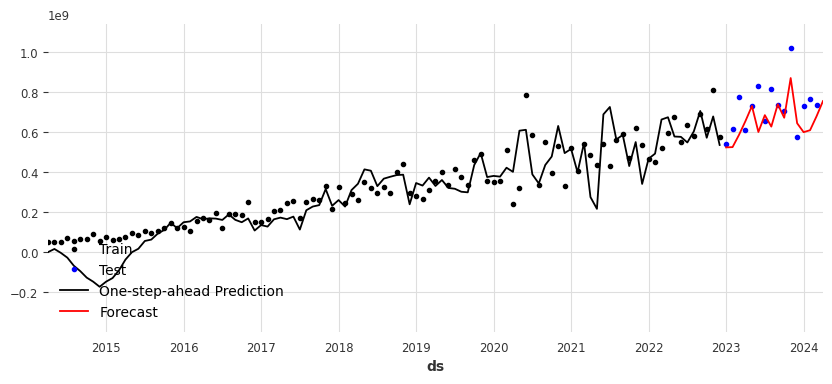

In [128]:
fig, ax = plt.subplots(figsize=(10,4))

# Plot the results
ssm_train['y'].plot(ax=ax, style='k.', label='Train')
ssm_test['y'].plot(ax=ax, style='b.', label='Test')
predict.predicted_mean.plot(ax=ax, label='One-step-ahead Prediction')
predict_ci = predict.conf_int(alpha=0.05)
predict_index = np.arange(len(predict_ci))
ax.fill_between(predict_index[2:], predict_ci.iloc[2:, 0], predict_ci.iloc[2:, 1], alpha=0.1)

forecast.predicted_mean.plot(ax=ax, style='r', label='Forecast')
forecast_ci = forecast.conf_int()
forecast_index = np.arange(len(predict_ci), len(predict_ci) + len(forecast_ci))
ax.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], alpha=0.1)

# Cleanup the image
legend = ax.legend(loc='lower left');


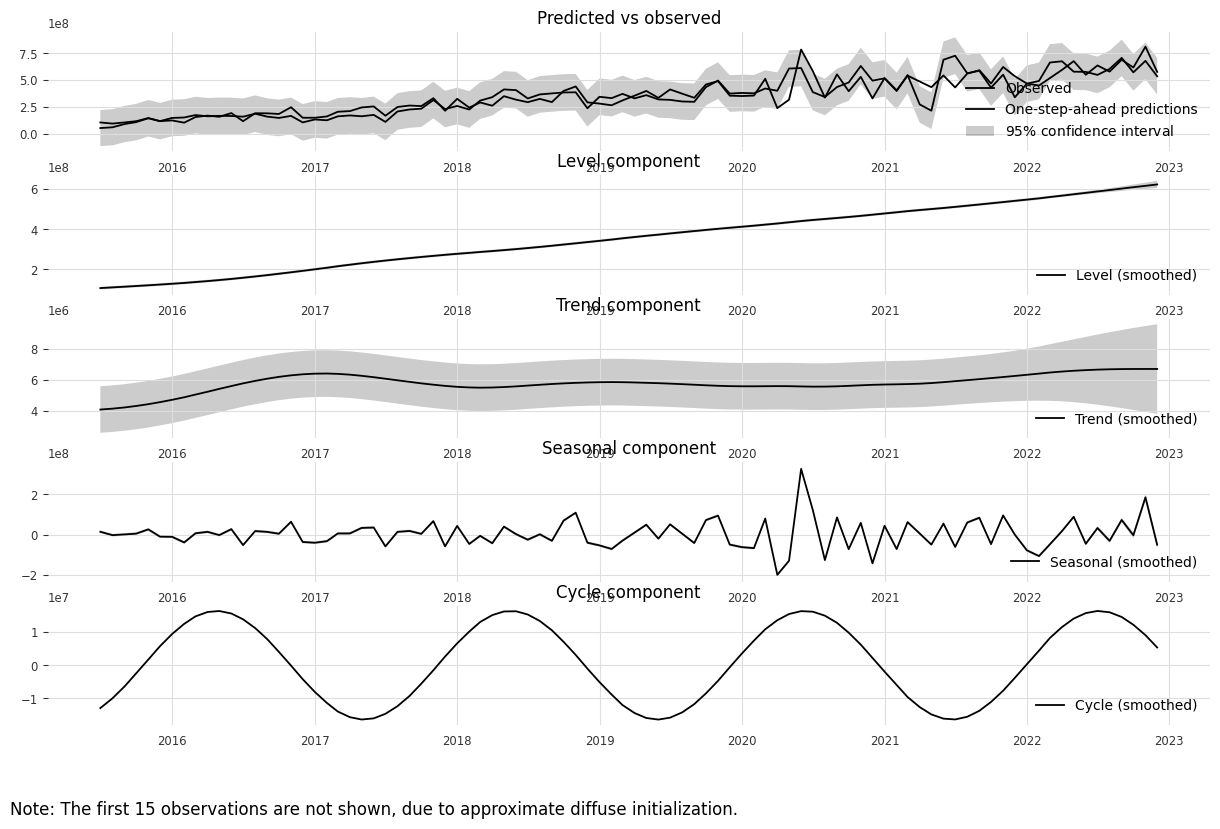

In [129]:
fig = res.plot_components(legend_loc='lower right', figsize=(15, 9));